In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import ipywidgets as wgt
import toml
from re import match, search
# from kalman_filter import undistort_points
%matplotlib widget

ROOTDIR = r'D:\Desktop\1076\662_2021-09-09_male_unknown_social_status_habituation'
# CONFIG_DIR = r'C:\Users\SchwartzLab\PycharmProjects\bahavior_rig\config_archive\2021-09-22-18-10-46_v3_config'
CONFIG_DIR = os.path.join(ROOTDIR,'config')

CAMERAS = [int(match('camera_(\d+).MOV',i).group(1)) for i in os.listdir(os.path.join(ROOTDIR,'raw'))]
TOP_CAMERA = 17391304
MARKERS = ['nose','left_ear','right_ear','skull_base','left_hip','right_hip','tail_base','tail_end']
MARKER_COLORS = np.array([[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1],[1,1,1],[1,.5,0]])
CAMERA_COLORS = np.array([[1,0,0,],[0,1,0],[0,0,1],[1,1,0]])

#this is a hacky bit of code to account for mismatches in the videos and the calibration version
CONFIG_CAMERAS =[search(r'_(\d+).toml', i) for i in os.listdir(CONFIG_DIR)]
CONFIG_CAMERAS = {int(i.group(1)) for i in CONFIG_CAMERAS if i is not None}
CONFIG_MAP = {k:k for k in CAMERAS if k in CONFIG_CAMERAS}
CONFIG_MAP = {**CONFIG_MAP, **{k:v for k,v in zip([c for c in CAMERAS if c not in CONFIG_CAMERAS], [c for c in CONFIG_CAMERAS if c not in CAMERAS])}}
print(CONFIG_MAP)

{17391290: 17391290, 17391304: 17391304, 19412282: 19412282, 21259803: 21259803}


In [2]:
top_ind = [i for i,c in enumerate(CAMERAS) if c==TOP_CAMERA][0]
#load the pose, videos, calibration
pose = []
caps = []
extrs = np.array(list(toml.load(os.path.join(CONFIG_DIR, 'config_extrinsic.toml'))['extrinsic'].values())).astype(float)
intrs = []
nK = []

for i in range(4):
    caps.append(cv2.VideoCapture(os.path.join(ROOTDIR,'raw',f'camera_{CAMERAS[i]}.MOV')))
    intrs.append(toml.load(os.path.join(CONFIG_DIR, f'config_intrinsic_{CONFIG_MAP[CAMERAS[i]]}.toml')))
    intrs[i]['camera_mat'] = np.array(intrs[i]['camera_mat'])
    intrs[i]['dist_coeff'] = np.array(intrs[i]['dist_coeff'])
    
    
    if i==top_ind:
        fname = f'camera_17391304DLC_dlcrnetms5_HipsDontLieBacksDoOct27shuffle1_200000_el_filtered.csv'
        undistortPoints = cv2.undistortPoints
        nK.append(cv2.getOptimalNewCameraMatrix(intrs[i]['camera_mat'],intrs[i]['dist_coeff'],(1280,1024),1)[0])
    else:
        fname = f'camera_{CAMERAS[i]}DLC_dlcrnetms5_SideCamera3Jan27shuffle1_200000_el_filtered.csv'
        undistortPoints = cv2.fisheye.undistortPoints
        nK.append(cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(intrs[i]['camera_mat'], intrs[i]['dist_coeff'], (1280,1024),np.eye(3), balance=.5))
    
    pose.append(pd.read_csv(os.path.join(ROOTDIR, 'DLC', fname), header = [1,2,3]).center_mouse[MARKERS])
    # for c in pose[i].columns.get_level_values(0).unique():
    #     pose[i].loc[:,(c,['x','y'])] = undistortPoints(pose[i].loc[:,(c,['x','y'])].to_numpy().reshape(-1,1,2), intrs[i]['camera_mat'],intrs[i]['dist_coeff']).squeeze()

frame_count = int(min([c.get(cv2.CAP_PROP_FRAME_COUNT) for c in caps]))
data = pd.read_csv(os.path.join(ROOTDIR, 'DLC', 'output_3d_data_kalman.csv'),header=[0,1]).to_numpy()
# print(pd.read_csv(os.path.join(ROOTDIR, 'DLC', 'output_3d_data_kalman.csv'),header=[0,1]).head)
# print(data.shape,frame_count)
pose3 = np.moveaxis(data.reshape((-1,6,data.shape[1]//6)), 1, 2)

# print(data.shape, pose3.shape, frame_count)

In [3]:
def reorient(extr,theta):
    #adjusts the angle of the camera about its principal axis
    # get the lookat and up vectors
    lookAt = -extr[2,:3]
    up = extr[1,:3]
    
    #rotate the up vector by the given angle
    up = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]]) @ up
    
    #reform the camera matrix
    s = np.cross(lookAt,up)
    s = s / np.linalg.norm(s)    
    return np.array([s,up,-lookAt])    
    
# extrs[-1][:3,:3] = reorient(extrs[-1][:3,:3],0.4)
# np.set_printoptions(precision=16)
# print(extrs[-1])

In [5]:
def xyz_to_xy(xyz, extrinsic, intrinsic, undistort=True):
    rvec, _ = cv2.Rodrigues(extrinsic[0:3, 0:3])
    tvec = extrinsic[0:3, 3]
    if undistort:
        dcs = np.zeros(intrinsic['dist_coeff'].shape)
    else:
        dcs = intrinsic['dist_coeff']
    if len(dcs) == 4:
        xy, _ = cv2.fisheye.projectPoints(xyz, rvec, tvec, intrinsic['camera_mat'], dcs)
    else:
        xy, _ = cv2.projectPoints(xyz, rvec, tvec, intrinsic['camera_mat'], dcs)
        
    return xy

def xy_to_xyz(xy, d, extrinsic, intrinsic, undistort=True):
    #each pixel maps to a line segment in world coordinates, with range defined by d
    #xy: (1-by-1-by-2)
    #d: (N-by-1)
    #xyz: (N-by-1-by-2)

    xy = xy.reshape((1,1,2))
    d = d.reshape((-1,1,1))

    cm = intrinsic['camera_mat']

    #1: undistort the points
    if undistort:
        if len(intrinsic['dist_coeff']) == 4:
            undistortPoints = cv2.fisheye.undistortPoints
        else:
            undistortPoints = cv2.undistortPoints
        xy = undistortPoints(xy, cm, intrinsic['dist_coeff'])

    #2: apply the inverted camera matrix
    xyh = cv2.transform(xy, np.linalg.inv(cm))

    # #3: map the depth
    xyh = np.concatenate((
        xy[:,:,:3] * d,
        d
    ), axis=2)

    #4: apply the inverted extrinsic matrix
    xyz = cv2.transform(xyh, np.linalg.inv(extrinsic))
    xyz = xyz [:,:,:3] / xyz[:,:,3].reshape(-1,1,1)
    return xyz

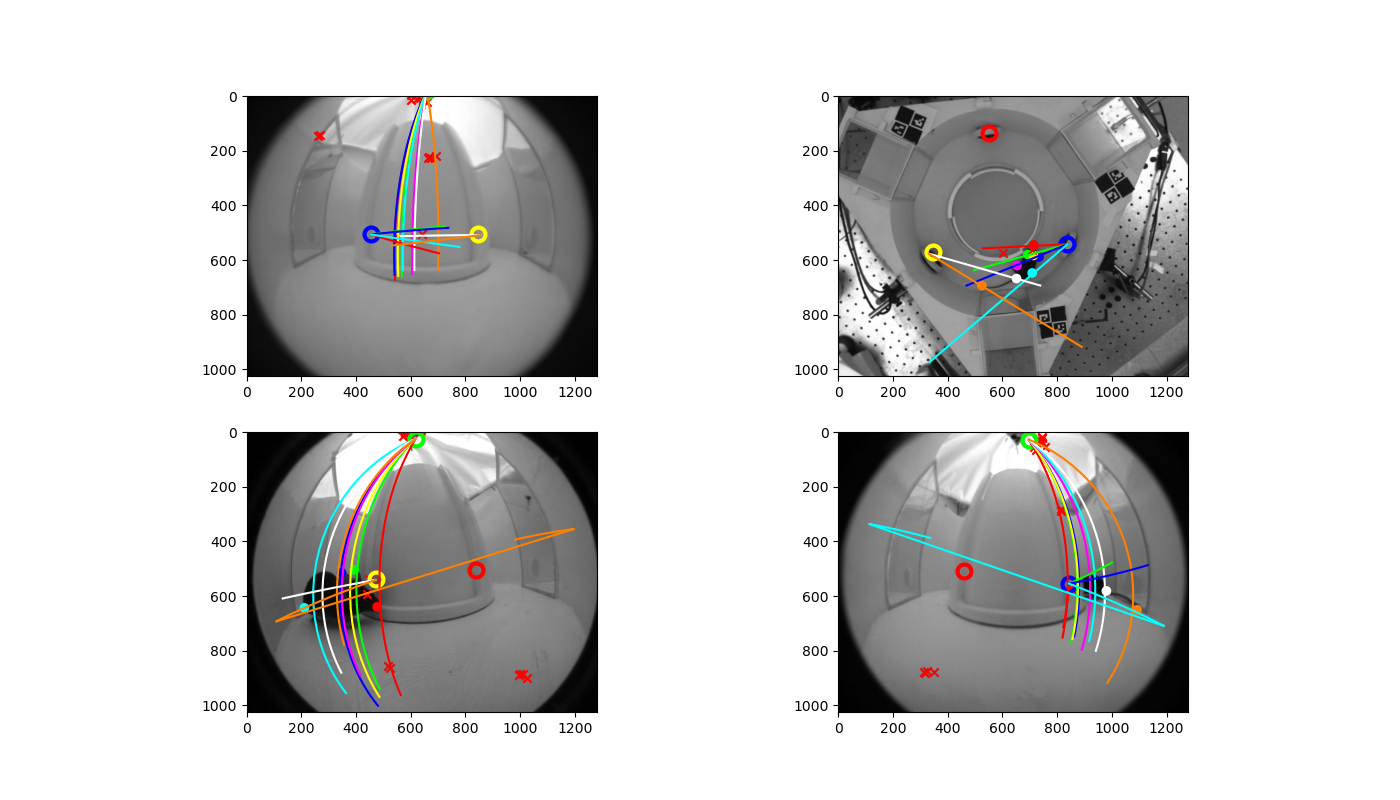

In [6]:
def show_projections():
    output = wgt.Output()
    with output:
        fig,axs = plt.subplots(2,2, figsize=(14,8))
    
    axs = axs.flatten()
    ims = [None for _ in range(4)]
    marks = [None for _ in range(4)]
    cams = [[None for __ in range(4)] for _ in range(4)]
    rays = [[[None for ___ in range(len(MARKERS))]for __ in range(4)] for _ in range(4)]
    d3 = [None for _ in range(4)]

    frame_init = 375

    for i in range(4):
        if i==top_ind:
            undistortImage = cv2.undistort
        else:
            undistortImage = cv2.fisheye.undistortImage

        caps[i].set(cv2.CAP_PROP_POS_FRAMES, frame_init) #seek to a common frame_init...
        # ims[i] = axs[i].imshow(undistortImage(caps[i].read()[1], intrs[i]['camera_mat'], intrs[i]['dist_coeff'], None, nK[i]))
        ims[i] = axs[i].imshow(caps[i].read()[1])
        marks[i] = axs[i].scatter(
            pose[i].iloc[frame_init, pose[i].columns.get_level_values(1)=='x'],
            pose[i].iloc[frame_init, pose[i].columns.get_level_values(1)=='y'],
            c=MARKER_COLORS
        )
        p3 = xyz_to_xy(pose3[frame_init].reshape(-1,1,3), extrs[i], intrs[i])
        d3[i] = axs[i].scatter(p3[:,:,0], p3[:,:,1],marker='x', color = 'red')

        for j in range(4):
            if i==j: continue
            pos3 = -extrs[j][:3,:3].T @ extrs[j][:3,3]
            # pos2 = xyz_to_xy(pos3.reshape((1,1,3)), extrs[i],{'camera_mat':nK[i], 'dist_coeff': intrs[i]['dist_coeff']}, undistort=False).flatten()
            pos2 = xyz_to_xy(pos3.reshape((1,1,3)), extrs[i],intrs[i], undistort=True).flatten()
            cams[i][j] = axs[i].scatter(pos2[0], pos2[1], s=100, linewidths=3, color='#00000000', edgecolors=CAMERA_COLORS[j])
            extent = 35 if j==top_ind else 5
            for k in range(len(MARKERS)):
                xyz = xy_to_xyz(
                np.array([pose[j][MARKERS[k]].x[frame_init], pose[j][MARKERS[k]].y[frame_init]]),
                np.linspace(0,extent,100), extrs[j], intrs[j], undistort=True
                )
                uv = xyz_to_xy(xyz, extrs[i], intrs[i], undistort = True)

                rays[i][j][k] = axs[i].plot(uv[:,:,0],uv[:,:,1],c=MARKER_COLORS[k])[0]
        axs[i].set_xlim((0,1280))
        axs[i].set_ylim((1024,0))

    def update(change):
        if change['name']!='value':
            return
        frame = change['new']
        for i in range(4):
            if i==top_ind:
                undistortImage = cv2.undistort
            else:
                undistortImage = cv2.fisheye.undistortImage

            caps[i].set(cv2.CAP_PROP_POS_FRAMES, frame)
            #ims[i].set_data(undistortImage(caps[i].read()[1], intrs[i]['camera_mat'], intrs[i]['dist_coeff'], None, nK[i]))
            ims[i].set_data(caps[i].read()[1])
            marks[i].set_offsets(np.concatenate((
                pose[i].iloc[frame, pose[i].columns.get_level_values(1)=='x'].to_numpy().reshape(-1,1),
                pose[i].iloc[frame, pose[i].columns.get_level_values(1)=='y'].to_numpy().reshape(-1,1)
            ), axis=1))

            p3 = xyz_to_xy(pose3[frame].reshape(-1,1,3), extrs[i], intrs[i]).reshape((-1,2))
            d3[i].set_offsets(p3)

            for j in range(4):
                if i==j: continue
                extent = 35 if j==top_ind else 5
                for k in range(len(MARKERS)):
                    xyz = xy_to_xyz(
                    np.array([pose[j][MARKERS[k]].x[frame], pose[j][MARKERS[k]].y[frame]]),
                    np.linspace(0,extent,100), extrs[j], intrs[j], undistort = True
                    )
                    uv = xyz_to_xy(xyz, extrs[i], intrs[i], undistort = True)
                    rays[i][j][k].set_data(uv[:,:,0],uv[:,:,1])

        
    
    frame_select = wgt.IntSlider(value=frame_init, min=0, max=frame_count)
    frame_select.observe(update)

    display(wgt.VBox([frame_select, output]))

plt.close('all')
show_projections()